In [1]:
import dataclasses as dc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def cat(*xs):
    return np.concatenate(xs)


@dc.dataclass
class Info:
    t: np.ndarray = None
    dt: np.ndarray = None

    dt_host_div_robot: np.ndarray = None
    
    success_rate: np.ndarray = None

    delta_angle_delayed: np.ndarray = None
    dot_delta_angle_delayed: np.ndarray = None

    q: np.ndarray = None
    dq: np.ndarray = None
    tau: np.ndarray = None
    tau_ext_filt: np.ndarray = None

    # From `robot_state`.
    q_d: np.ndarray = None
    dq_d: np.ndarray = None
    dq_d_diff: np.ndarray = None

    # From logged commands.
    q_c: np.ndarray = None
    dq_c_diff: np.ndarray = None

    q_d_error: np.ndarray = None
    q_c_error: np.ndarray = None
    q_cd_error: np.ndarray = None

    @staticmethod
    def from_csv(file):        
        info = Info()
        dt = 1e-3

        df = pd.read_csv(file, sep=r'\s*,\s*', engine='python')

        t_host_abs = df['host_time']
        dt_host_raw = np.diff(t_host_abs)
        # robot time is only 1ms resolution :(
        t_abs = df['time']
        dt_raw = np.diff(t_abs)

        dt_ratio = dt_host_raw / dt_raw
        info.dt_host_div_robot = cat([0.0], dt_ratio)

        def compute_dx(x):
            dx = np.diff(x) / dt_raw
            # Prepend with first so its the same size as t.
            return cat([dx[0]], dx)
        
        info.t = t_abs - t_abs[0]
        info.dt = cat([0.0], dt_raw)
        info.success_rate = df['success_rate']
        info.q = df['q[3]']
        info.dq = df['dq[3]']
        info.tau = df['tau_J[3]']
        info.tau_ext_filt = df['tau_ext_hat_filtered[3]']

        # First one is RobotState.
        info.q_d = df['q_d[3]']
        info.dq_d = df['dq_d[3]']
        info.dq_d_diff = compute_dx(info.q_d)
        # Compute error, actual - desired
        info.q_d_error = info.q - info.q_d

        # Second is RobotCommand (for logging).
        info.q_c = df['q_c[3]'].copy()
        # Latch first.
        info.dq_c_diff = compute_dx(info.q_c)
        
        info.delta_angle_delayed = df['delta_angle_delayed']
        info.dot_delta_angle_delayed = compute_dx(info.delta_angle_delayed)

        # diff.
        info.q_c_error = info.q - info.q_c
        info.q_cd_error = info.q_d - info.q_c
        return info

In [3]:
names = [
    "delay_time_0",
    "delay_time_1",
    "delay_time_50",
    "delay_buffer_0",
    "delay_buffer_1",
    "delay_buffer_50",
]
data = {}
for name in names:
    data[name] = Info.from_csv(f"./data/{name}.log")

delay_time_0: n=4981
delay_time_1: n=4970
delay_time_50: n=4954
delay_buffer_0: n=4955
delay_buffer_1: n=4959
delay_buffer_50: n=4974


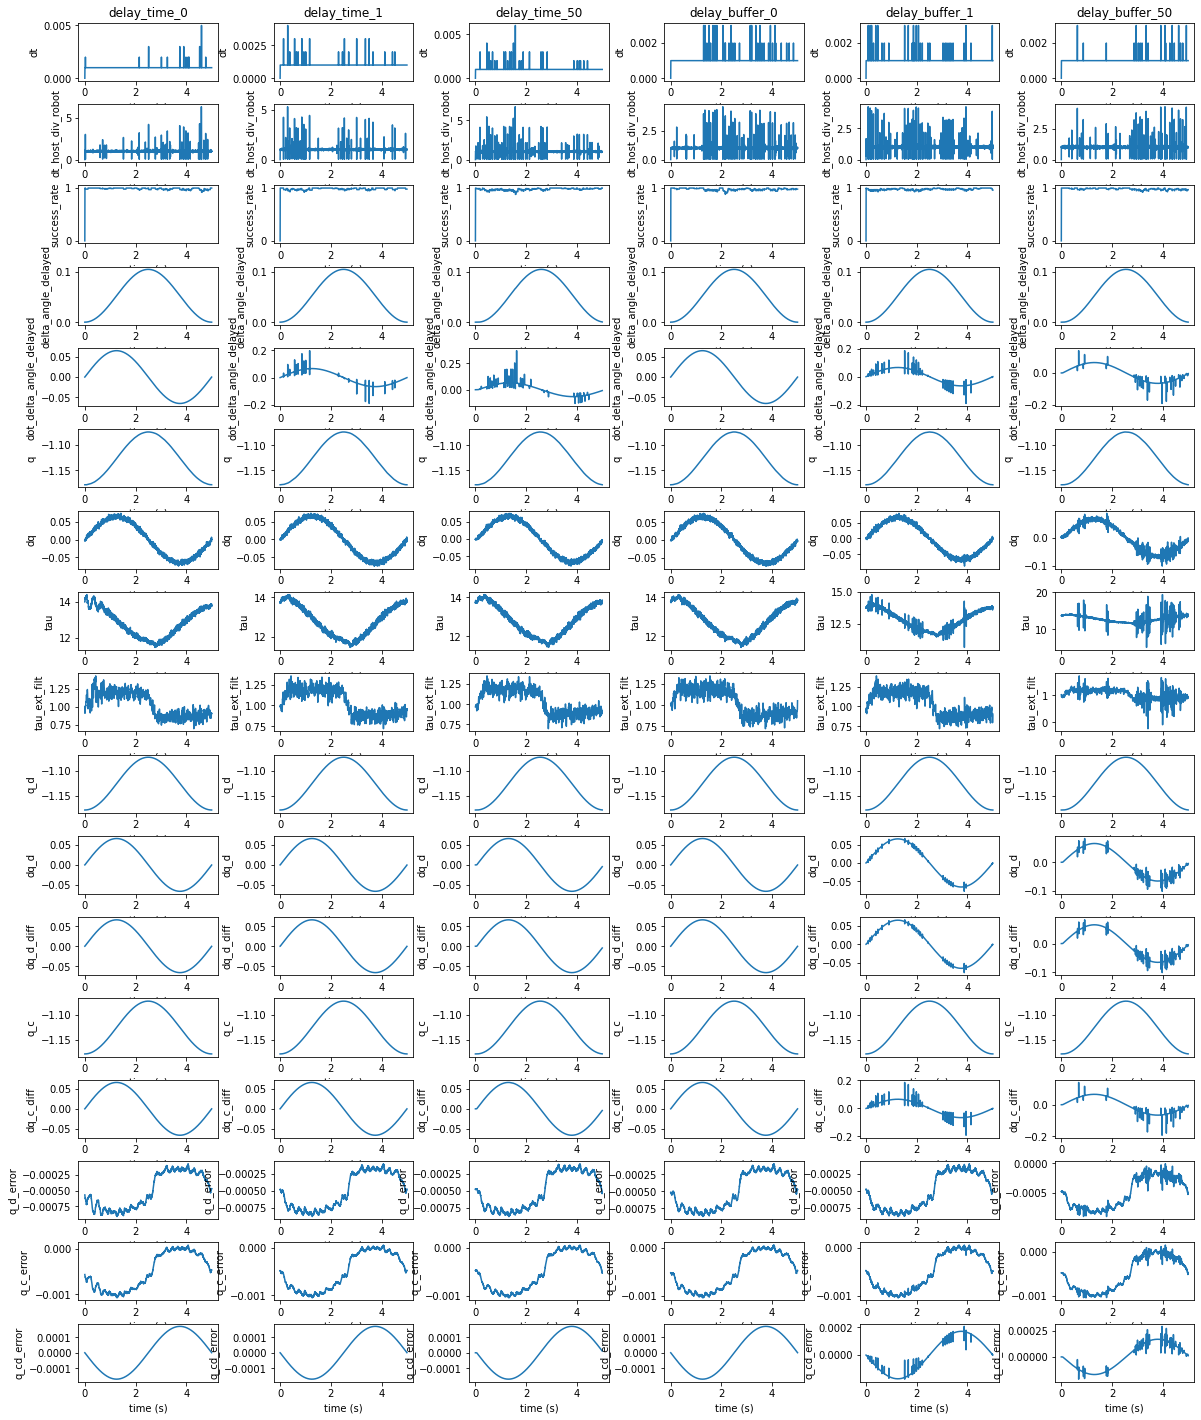

In [4]:
fields = dc.fields(Info)[1:]
N = len(fields)
_, axs = plt.subplots(nrows=N, ncols=len(data), figsize=(20, 25), squeeze=False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for c, (label, info) in enumerate(data.items()):
    print(f"{label}: n={len(info.t)}")
    for r, field in enumerate(fields):
        name = field.name
        value = getattr(info, name)
        ax = axs[r, c]
        plt.sca(ax)
        plt.plot(info.t, value)
        plt.ylabel(name)
        plt.xlabel('time (s)')
        if r == 0:
            plt.title(label)